# SVM & Adaboost Algorithm using Bitcoin daily data from yfinance from 9-10-2014 - 9-10-2023

In [92]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import talib
from sklearn.model_selection import GridSearchCV

### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [73]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("BTC-AUD.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-09,399.171661,435.658539,391.848328,416.601227,416.601227,95458918
2014-10-10,416.214355,427.426758,405.331879,416.306274,416.306274,50277145
2014-10-11,416.075989,422.787567,409.845703,417.154877,417.154877,15365803
2014-10-12,417.508331,437.739990,410.067963,436.267151,436.267151,20229111
2014-10-13,435.543365,453.506134,422.562439,446.136444,446.136444,40248429


## Create daily returns

In [74]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["Close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2014-10-10,416.306274,-0.000708
2014-10-11,417.154877,0.002038
2014-10-12,436.267151,0.045816
2014-10-13,446.136444,0.022622
2014-10-14,460.293945,0.031734


,Close,Actual Returns
Date,,
2023-10-05,43926.378906,0.010259
2023-10-06,43045.859375,-0.020045
2023-10-07,43775.996094,0.016962
2023-10-08,43810.835938,0.000796
2023-10-09,43768.171875,-0.000974


## Generate trading indicators using Simple Moving Average and MACD. 

In [75]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

# Add MACD
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9

signals_df['macd'], signals_df['macdSignal'], signals_df['macdHist'] = talib.MACD(signals_df['Close'], fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
signals_df

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,,,
2015-01-17,242.290848,-0.042466,242.351833,402.940476,-38.776091,-29.038767,-9.737324
2015-01-18,255.793518,0.055729,251.593556,401.335349,-38.807069,-30.992428,-7.814642
2015-01-19,262.313507,0.025489,253.358528,399.786935,-37.868981,-32.367738,-5.501243
2015-01-20,258.901001,-0.013009,254.824719,398.013273,-36.974679,-33.289127,-3.685553
2015-01-21,280.085175,0.081823,264.273300,396.352761,-34.162746,-33.463850,-0.698896


,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,,,
2023-10-05,43926.378906,0.010259,43538.310547,43031.339336,562.980640,271.561881,291.418759
2023-10-06,43045.859375,-0.020045,43431.859375,43002.548008,564.027279,330.054961,233.972319
2023-10-07,43775.996094,0.016962,43557.133789,42984.380391,616.664159,387.376800,229.287359
2023-10-08,43810.835938,0.000796,43639.767578,42962.390703,653.655615,440.632563,213.023052
2023-10-09,43768.171875,-0.000974,43600.215821,42942.654609,671.785057,486.863062,184.921995


## Create signal for +/- daily returns

In [76]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist,Signal
Date,,,,,,,,
2015-01-17,242.290848,-0.042466,242.351833,402.940476,-38.776091,-29.038767,-9.737324,-1.0
2015-01-18,255.793518,0.055729,251.593556,401.335349,-38.807069,-30.992428,-7.814642,1.0
2015-01-19,262.313507,0.025489,253.358528,399.786935,-37.868981,-32.367738,-5.501243,1.0
2015-01-20,258.901001,-0.013009,254.824719,398.013273,-36.974679,-33.289127,-3.685553,-1.0
2015-01-21,280.085175,0.081823,264.273300,396.352761,-34.162746,-33.463850,-0.698896,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist,Signal
Date,,,,,,,,
2023-10-05,43926.378906,0.010259,43538.310547,43031.339336,562.980640,271.561881,291.418759,1.0
2023-10-06,43045.859375,-0.020045,43431.859375,43002.548008,564.027279,330.054961,233.972319,-1.0
2023-10-07,43775.996094,0.016962,43557.133789,42984.380391,616.664159,387.376800,229.287359,1.0
2023-10-08,43810.835938,0.000796,43639.767578,42962.390703,653.655615,440.632563,213.023052,1.0
2023-10-09,43768.171875,-0.000974,43600.215821,42942.654609,671.785057,486.863062,184.921995,-1.0


In [77]:
signals_df['Signal'].value_counts()

 1.0    1687
-1.0    1501
Name: Signal, dtype: int64

<Axes: xlabel='Date'>

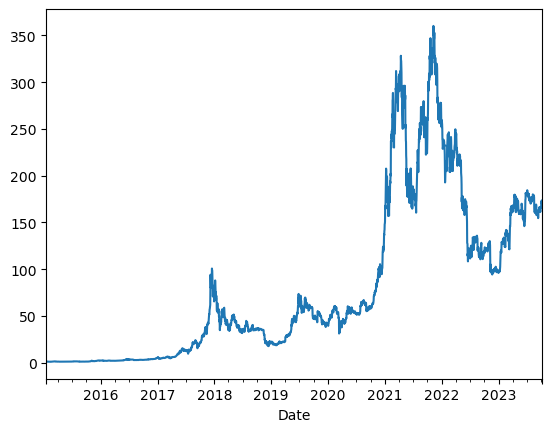

In [78]:
# Plot Daily Returns to examine performance
(1 + signals_df['Actual Returns']).cumprod().plot()

### Split the data into training and testing datasets.

In [82]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow','macd','macdSignal','macdHist']].shift().dropna()

# Review the DataFrame
X

,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,
2015-01-18,242.351833,402.940476,-38.776091,-29.038767,-9.737324
2015-01-19,251.593556,401.335349,-38.807069,-30.992428,-7.814642
2015-01-20,253.358528,399.786935,-37.868981,-32.367738,-5.501243
2015-01-21,254.824719,398.013273,-36.974679,-33.289127,-3.685553
2015-01-22,264.273300,396.352761,-34.162746,-33.463850,-0.698896
...,...,...,...,...,...
2023-10-05,43045.185547,43045.650313,463.803040,198.707191,265.095848
2023-10-06,43538.310547,43031.339336,562.980640,271.561881,291.418759
2023-10-07,43431.859375,43002.548008,564.027279,330.054961,233.972319


In [83]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']
display(y)
# Review the value counts
y.value_counts()

Date
2015-01-17   -1.0
2015-01-18    1.0
2015-01-19    1.0
2015-01-20   -1.0
2015-01-21    1.0
             ... 
2023-10-05    1.0
2023-10-06   -1.0
2023-10-07    1.0
2023-10-08    1.0
2023-10-09   -1.0
Name: Signal, Length: 3188, dtype: float64

 1.0    1687
-1.0    1501
Name: Signal, dtype: int64

In [84]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-01-18 00:00:00


In [85]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=30)

# Display the training end date
print(training_end)

2017-07-18 00:00:00


In [86]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train

,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,
2015-01-18,242.351833,402.940476,-38.776091,-29.038767,-9.737324
2015-01-19,251.593556,401.335349,-38.807069,-30.992428,-7.814642
2015-01-20,253.358528,399.786935,-37.868981,-32.367738,-5.501243
2015-01-21,254.824719,398.013273,-36.974679,-33.289127,-3.685553
2015-01-22,264.273300,396.352761,-34.162746,-33.463850,-0.698896
...,...,...,...,...,...
2017-07-14,3087.886536,2683.994771,-59.020801,-19.014311,-40.006490
2017-07-15,3021.205994,2697.656710,-84.346952,-32.080839,-52.266113
2017-07-16,2894.290466,2707.503964,-127.123111,-51.089293,-76.033817


In [87]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]

# Review the X_test DataFrame
# X_train.head()
X_test

,SMA_Fast,SMA_Slow,macd,macdSignal,macdHist
Date,,,,,
2017-07-19,2702.741882,2742.848455,-153.794173,-104.289801,-49.504372
2017-07-20,2778.479859,2755.594865,-150.412209,-113.514282,-36.897927
2017-07-21,3048.171326,2774.987417,-91.044873,-109.020400,17.975528
2017-07-22,3175.798950,2792.778984,-57.352418,-98.686804,41.334386
2017-07-23,3331.686402,2812.840132,-15.946450,-82.138733,66.192283
...,...,...,...,...,...
2023-10-05,43045.185547,43045.650313,463.803040,198.707191,265.095848
2023-10-06,43538.310547,43031.339336,562.980640,271.561881,291.418759
2023-10-07,43431.859375,43002.548008,564.027279,330.054961,233.972319


## Standardise feature data

In [88]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Use the `SVC` classifier model from SKLearn's support vector machine (SVM) and the Adaboost Classifier. 

In [89]:
svc=SVC(probability=True, kernel='linear', random_state=1, gamma='auto')

# From SVM, instantiate SVC classifier model instance
abc_model = AdaBoostClassifier(
          n_estimators=25, estimator=svc,learning_rate=0.5, random_state=1
)
parameters = {'n_estimators':[25,50], 'learning_rate':[0.5]}

#grid search cv abc_model
clf_model = GridSearchCV(abc_model, parameters)

# Fit the model to the data using the training data
# model = abc_model.fit(X_train_scaled, y_train)
model = clf_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
y_pred = model.predict(X_test_scaled)

# Review the model's predicted values
results = pd.DataFrame({
    "Prediction": y_pred, 
    "Actual": y_test
}).reset_index(drop=True)
results



,Prediction,Actual
0,1.0,-1.0
1,1.0,1.0
2,1.0,-1.0
3,1.0,1.0
4,1.0,-1.0
...,...,...
2269,1.0,1.0
2270,1.0,-1.0
2271,1.0,1.0
2272,1.0,1.0


In [90]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print(model.best_params_)

Accuracy: 0.5114335971855761
{'learning_rate': 0.5, 'n_estimators': 25}


### Review the classification report associated with the `SVC` model predictions. 

In [91]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.47      0.02      0.03      1109
         1.0       0.51      0.98      0.67      1165

    accuracy                           0.51      2274
   macro avg       0.49      0.50      0.35      2274
weighted avg       0.49      0.51      0.36      2274



### Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [70]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = y_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2017-07-19,1.0,-0.024650,-0.024650
2017-07-20,1.0,0.241389,0.241389
2017-07-21,1.0,-0.048991,-0.048991
2017-07-22,1.0,0.053363,0.053363
2017-07-23,1.0,-0.030085,-0.030085


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-10-05,1.0,0.010259,0.010259
2023-10-06,1.0,-0.020045,-0.020045
2023-10-07,1.0,0.016962,0.016962
2023-10-08,1.0,0.000796,0.000796
2023-10-09,1.0,-0.000974,-0.000974


### Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

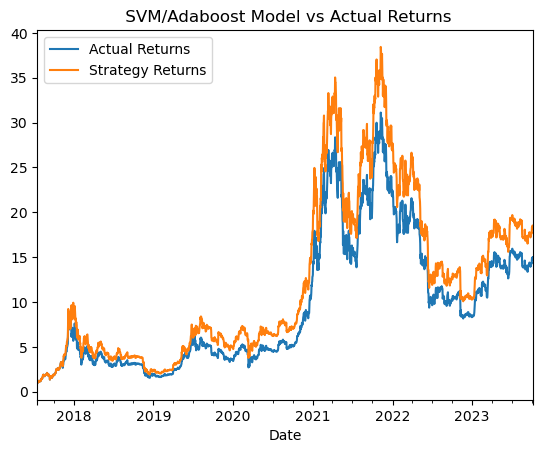

In [72]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(title=' SVM/Adaboost Model vs Actual Returns')
plt.savefig('SVM_Adaboost_plot.png')